In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
from scipy.optimize import minimize

Tickers & Time Range

In [2]:
tickers = ['ZOMATO.NS','BHARTIARTL.NS','PAYTM.NS','SWIGGY.NS','NYKAA.NS']

In [3]:
end_date = datetime.today()

In [4]:
start_date=end_date-timedelta(days=2*365)

Adjusted Close Prices

In [5]:
adj_close_df = pd.DataFrame()

In [6]:
for ticker in tickers:
    data=yf.download(ticker,start=start_date,end=end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
print(adj_close_df)

             ZOMATO.NS  BHARTIARTL.NS    PAYTM.NS   SWIGGY.NS    NYKAA.NS
Date                                                                     
2023-01-09   56.000000     811.133057  563.900024         NaN  152.949997
2023-01-10   54.700001     784.850891  575.549988         NaN  150.500000
2023-01-11   54.349998     757.826355  579.150024         NaN  155.100006
2023-01-12   53.750000     749.263611  543.200012         NaN  149.800003
2023-01-13   53.250000     756.588928  560.099976         NaN  147.600006
...                ...            ...         ...         ...         ...
2025-01-01  276.500000    1595.699951  987.599976  542.349976  164.679993
2025-01-02  284.600006    1609.699951  982.400024  556.450012  165.320007
2025-01-03  272.850006    1598.849976  982.799988  541.450012  167.839996
2025-01-06  264.850006    1588.449951  969.049988  532.099976  171.520004
2025-01-07  252.449997    1590.849976  983.200012  509.250000  172.309998

[491 rows x 5 columns]


Calculating Log-Normal Returns

In [8]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [9]:
log_returns = log_returns.dropna()

Covariance Matrix

In [10]:
cov_matrix = log_returns.cov()*252

In [11]:
cov_matrix

,ZOMATO.NS,BHARTIARTL.NS,PAYTM.NS,SWIGGY.NS,NYKAA.NS
ZOMATO.NS,0.137507,-0.004643,0.031015,0.111176,0.011118
BHARTIARTL.NS,-0.004643,0.058612,0.004685,-0.003616,-0.017028
PAYTM.NS,0.031015,0.004685,0.127416,0.023525,0.003323
SWIGGY.NS,0.111176,-0.003616,0.023525,0.358915,0.032961
NYKAA.NS,0.011118,-0.017028,0.003323,0.032961,0.066417


Portfolio Performance Metrics

Portfolio st. dev

In [12]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

Expected Return

In [13]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

Sharpe Ratio

In [14]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

Portfolio Optimization

Risk Free Rate

In [15]:
#risk free rate 7%
risk_free_rate = .07

Neg Sharpe Ratio for Scipy Cal.

In [16]:
def neg_sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

Constraints & Bound Setting

In [17]:
constraints = {'type':'eq','fun':lambda weights: np.sum(weights)-1}
bounds = [(0,.4) for _ in range (len(tickers))]

Initial Weights

In [18]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


Optimize the weights to maximize the Sharpe Ratio

In [19]:
optimized_results = minimize(neg_sharpe_ratio,initial_weights, 
                             args=(log_returns, cov_matrix,risk_free_rate), method='SLSQP',
                             constraints = constraints, bounds = bounds)

In [20]:
optimal_weights = optimized_results.x

Analyze the Optimal Portfolio

In [21]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight*100:.4f}%")
    
print('\n')

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return*100:.4f}%")
print(f"Expected Volatility: {optimal_portfolio_volatility*100:.4f}%")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
ZOMATO.NS: 0.0000%
BHARTIARTL.NS: 33.4418%
PAYTM.NS: 40.0000%
SWIGGY.NS: 7.9428%
NYKAA.NS: 18.6154%


Expected Annual Return: 86.8192%
Expected Volatility: 18.2793%
Sharpe Ratio: 4.3667


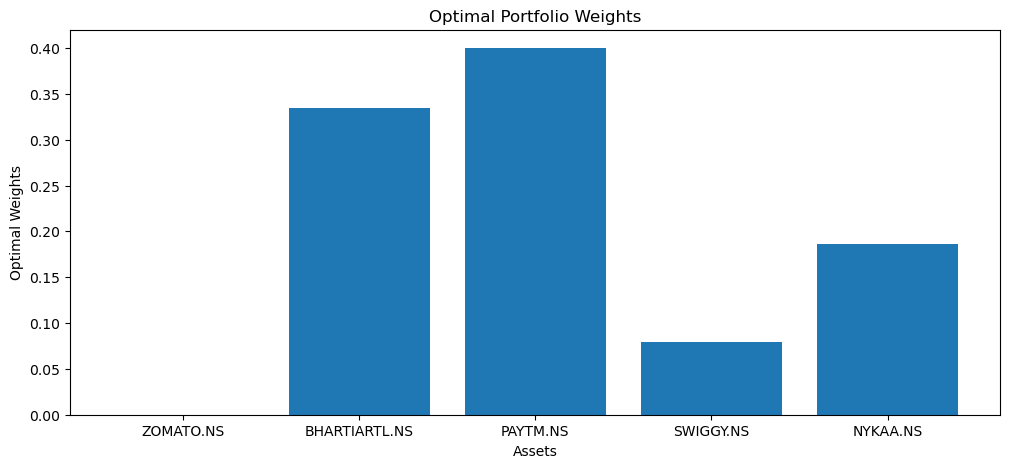

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()